# Business Requirement:

So this week we are looking at a problem in ***cybersecurity.*** We're dealing with a big company here that has a lot of firewall interaction. Now what they're asking us to do is to build a program about whether or not to accept or deny access to requests coming in.

They want us to automate it because, currently, their current system is taking up a lot of manpower and a lot of resources. So they have all the ***historical data** from before of how they've chosen to accept and deny these requests. So the model needs to be able to filter the incoming requests.

We need to classify them. And then it needs to be able to auto accept or auto deny the request. We want the best, most advanced model. It needs to be accurate, and it needs to function at speed.

So you have about ***60,000 rows*** of data to play with. And in the end, whether we put this model together, we're going to need a report on the level of accuracy and the level of performance so that they can make the decision on whether or not this can be implemented. 

***Build firewall classification model to classify whether or not to accept or deny access to requests coming in***

In [56]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")

#for data
import pandas as pd 
import numpy as np 

# scikit-learn's SimpleImputer to replace "nan" values
from sklearn.impute import SimpleImputer

# Display all columns 
pd.options.display.max_columns = None
## for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.classifier import ClassificationReport



from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score

import time
import os
# For loading .arff files
from scipy.io import arff
import urllib.request
import io # for io.StringIO()
import copy
# To analyze the type of missing data
import missingno as msno


### Common Functions

In [27]:
# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(df_encoding, features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    df_data_copy = df_encoding.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(df_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        df_encoding = pd.concat([df_data_copy,feat_df], axis=1)
        df_encoding = df_encoding.drop(columns = features_of_interest, axis = 1)
    return df_encoding
def plot_class_dist(y, target_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('Target Class Distribution:', target_label);
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('Target Class Counts:', target_label);

def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_confusion_matrix(y_test, y_hat):
    cm=metrics.confusion_matrix(y_test, y_hat)
    cm/np.sum(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{var1}\n{var2}\n{var3}" for var1,var2,var3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7,5))

    sns.heatmap(cm,
                annot=labels,
                fmt='',
                cmap='coolwarm',
                xticklabels=['Negative or 0','Positive or 1'],
                yticklabels=['Negative or 0','Positive or 1'],
                annot_kws={'size':16})

    plt.title('Confusion Matrix')
    plt.show()

# this function will plot precision and recall curve
def plot_precision_recall(X_test, y_test, model):
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    disp = plot_precision_recall_curve(model, X_test, y_test)

    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
def plot_AUC_roc_curve_(y_test, y_pred, classifier, model_name):
    ns_probs = [0 for _  in range(len(y_test))]
    y_pred_prob = classifier.predict_proba(X_test)
    y_pred_prob = y_pred_prob[:,1]
    ns_auc = metrics.roc_auc_score(y_test,ns_probs)

    ns_fpr,ns_tpr, _ = metrics.roc_curve(y_test,ns_probs)
    classifier_fpr,classifier_tpr, _ = metrics.roc_curve(y_test,y_pred_prob)

    nb_roc_auc = metrics.roc_auc_score(y_test,y_pred)

    plt.plot(ns_fpr,ns_tpr,linestyle = '--',color='red')
    plt.plot(classifier_fpr,classifier_tpr,marker='o',color='orange',label= model_name + ' (area = %0.3f)' % nb_roc_auc)
    plt.ylabel('True Positive Rate',size=14)
    plt.xlabel('False Positive Rate',size=14)
    plt.title(model_name + ' AUC-ROC curve',size=18)
    plt.rcParams['axes.spines.right']=True # remove the plot border
    plt.rcParams['axes.spines.left']=True # remove the plot border
    plt.rcParams['axes.spines.top']=True # remove the plot border
    plt.rcParams['axes.spines.bottom']=True #
    plt.legend() 
    plt.show()
def log_transform(df, numerical_features):
    for f in numerical_features:
        df[f] = np.log(df[f]+1)
    return df
    

In [28]:
data = 'https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy5/log2.csv'
df = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy5/log2.csv')

In [29]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [31]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [32]:
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [33]:
# print the number of records and attributes in the dataframe
records = len(df)
attributes = df.columns
print(f'Total Number of Records: {records} \nTotal Number of Attributes: {len(attributes)}')

Total Number of Records: 65532 
Total Number of Attributes: 12


In [34]:
def checkDuplicate (df):
    df_duplicates = df.groupby(df.columns.tolist(),as_index=False).size()
    duplicates = len(df_duplicates.loc[df_duplicates['size'] > 1])
    if duplicates == 0:
        print('NO, duplicate instances are not present')
    else:
        print('Yes, duplicate instances are present')
# lets check if duplicate instances are present
dup_result = checkDuplicate(df)

Yes, duplicate instances are present


In [35]:
df.drop_duplicates(inplace = True)
df.shape

(57170, 12)

Duplicates are calculated based on Source Port. There are Source Port with similar numbers. 

In [36]:
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

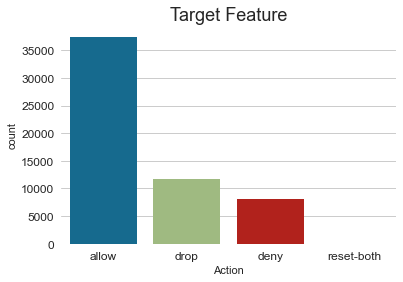

In [37]:
sns.countplot(x='Action',data=df) 
plt.title('Target Feature',size=18)
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=12)
plt.yticks(size=12) 
plt.show()

In [38]:
# Is this a multi-class problem? 
df['Action'].value_counts()

allow         37439
drop          11635
deny           8042
reset-both       54
Name: Action, dtype: int64

In [39]:
df['Bytes Sent'].value_counts()

70        9845
66        6866
94        3904
102       3517
62        2813
          ... 
7983         1
3885         1
337459       1
5717         1
10029        1
Name: Bytes Sent, Length: 6683, dtype: int64

In [40]:
df.head(2)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9


In [41]:
numerical_features = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
categorical_features = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
df[numerical_features].head()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,177,94,83,2,30,1,1
1,4768,1600,3168,19,17,10,9
2,238,118,120,2,1199,1,1
3,3327,1438,1889,15,17,8,7
4,25358,6778,18580,31,16,13,18


In [42]:
# Init, fit
#ss = StandardScaler()
#_ = ss.fit(df[numerical_features])
# Transform
#df[numerical_features] = pd.DataFrame(ss.transform(df[numerical_features]), columns=numerical_features)


df = log_transform(df, numerical_features)

In [43]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,5.181784,4.553877,4.430817,1.098612,3.433987,0.693147,0.693147
1,56258,3389,56258,3389,allow,8.469892,7.378384,8.061171,2.995732,2.890372,2.397895,2.302585
2,6881,50321,43265,50321,allow,5.476464,4.779123,4.795791,1.098612,7.090077,0.693147,0.693147
3,50553,3389,50553,3389,allow,8.110127,7.271704,7.544332,2.772589,2.890372,2.197225,2.079442
4,50002,443,45848,443,allow,10.140889,8.821585,9.829895,3.465736,2.833213,2.639057,2.944439


In [44]:
df[categorical_features] = df[categorical_features].astype(str)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57170 entries, 0 to 65530
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Source Port           57170 non-null  object 
 1   Destination Port      57170 non-null  object 
 2   NAT Source Port       57170 non-null  object 
 3   NAT Destination Port  57170 non-null  object 
 4   Action                57170 non-null  object 
 5   Bytes                 57170 non-null  float64
 6   Bytes Sent            57170 non-null  float64
 7   Bytes Received        57170 non-null  float64
 8   Packets               57170 non-null  float64
 9   Elapsed Time (sec)    57170 non-null  float64
 10  pkts_sent             57170 non-null  float64
 11  pkts_received         57170 non-null  float64
dtypes: float64(7), object(5)
memory usage: 8.2+ MB


Feature: Source Port
27005    513
57470    222
49418    209
6881     145
443      135
50584    116
26900    102
42298     84
3478      80
48817     77
Name: Source Port, dtype: int64



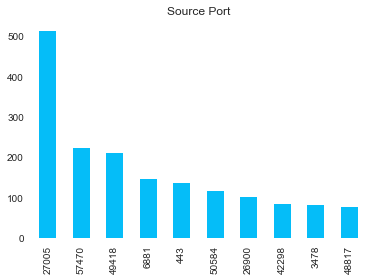

Feature: Destination Port
53       15389
443      11684
445      11674
80        4035
25174      686
22114      490
50584      460
64147      396
44847      382
23         344
Name: Destination Port, dtype: int64



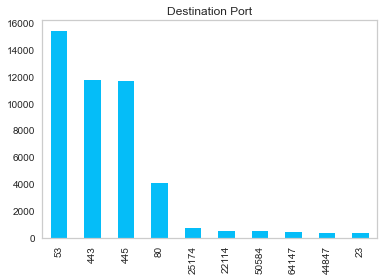

Feature: NAT Source Port
0        20125
48817       78
50116        9
58638        9
7986         5
60868        5
43757        5
57880        5
14591        5
30399        5
Name: NAT Source Port, dtype: int64



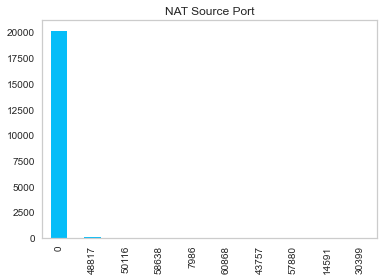

Feature: NAT Destination Port
0        20125
53       15093
443      11678
80        4028
27015      234
27017      160
123        156
3389       156
6881       142
5228       100
Name: NAT Destination Port, dtype: int64



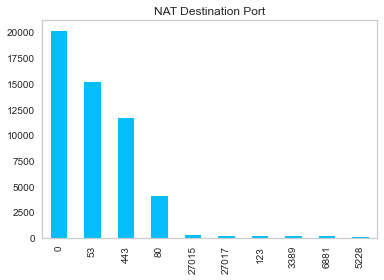

In [46]:
# show only top 10 levels for each feature
for f in categorical_features:
    print('Feature:', f)
    print(df[f].value_counts()[0:10])
    print()
    df[f].value_counts()[0:10].plot(kind='bar', color="#05BDF8")
    plt.rcParams['axes.spines.right']=True # add the plot border
    plt.rcParams['axes.spines.left']=True # add the plot border
    plt.rcParams['axes.spines.top']=True # add the plot border
    plt.rcParams['axes.spines.bottom']=True # add the plot border
    plt.title(f)
    plt.grid()
    plt.show()

Feature:Source Port - Top 10 levels only


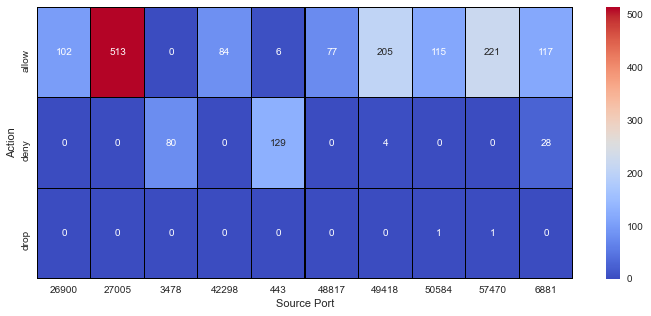

Feature:Destination Port - Top 10 levels only


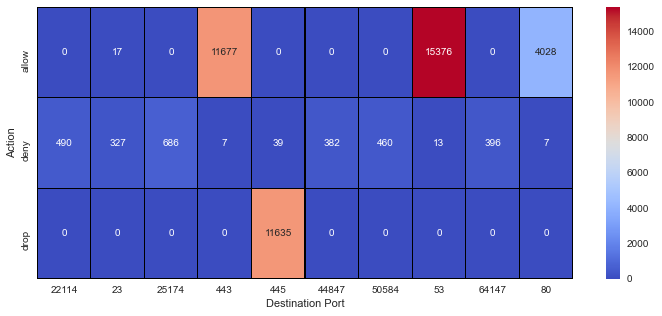

Feature:NAT Source Port - Top 10 levels only


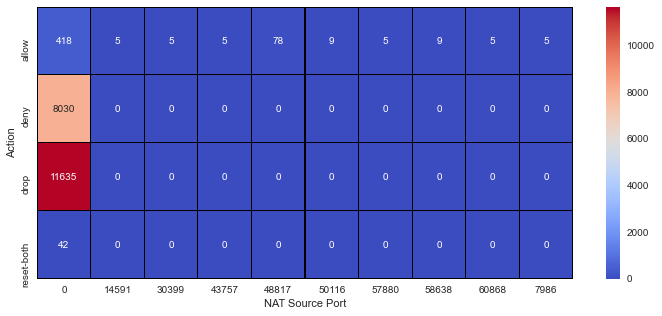

Feature:NAT Destination Port - Top 10 levels only


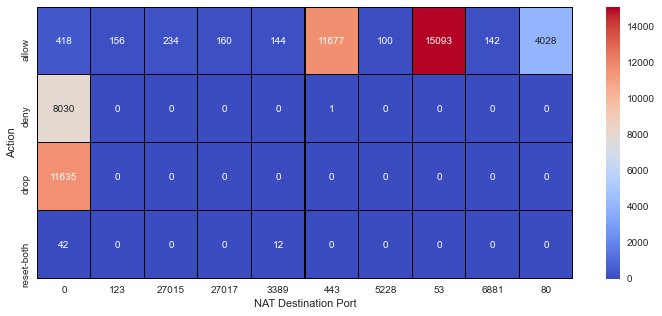

In [47]:
# visualize crosstable target vs feature (using top 10 levels only)
for f in categorical_features:
    top10_levels = df[f].value_counts()[0:10].index.to_list()
    df_temp = df[df[f].isin(top10_levels)]
    ctab = pd.crosstab(df_temp.Action, df_temp[f])
    print('Feature:' + f + ' - Top 10 levels only')
    plt.figure(figsize=(12,5))
    sns.heatmap(ctab, annot=True, fmt='d', 
                cmap='coolwarm',
                linecolor='black',
                linewidths=0.1)
    plt.show()

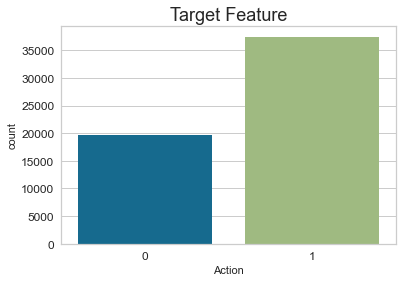

In [48]:
df['Action']=df['Action'].map({'allow':1,'drop':0, 'deny':0, 'reset-both':0})
sns.countplot(x='Action',data=df) 
plt.title('Target Feature',size=18)
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=12)
plt.yticks(size=12) 
plt.show()

In [49]:


y = df['Action']
X = df.drop(columns = ['Action'], axis = 1)

X_dummy_enc = create_dummy_encod(X, categorical_features, drop_first_cat=True, sparsity=True)

# Break our data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_dummy_enc, y, test_size=0.20, random_state=1234, stratify=y)

In [50]:
#plt.scatter(X_train, y_train, cmap='winter')

In [51]:
#svm_classifier = svm.SVC(kernel='linear', probability=True)
#svm_model = svm_classifier.fit(X_train, y_train)

svm_classifier = svm.LinearSVC(random_state = 1234)
svm_model = svm_classifier.fit(X_train, y_train)

In [52]:
y_pred = svm_model.predict(X_test)

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3946
           1       1.00      1.00      1.00      7488

    accuracy                           1.00     11434
   macro avg       1.00      1.00      1.00     11434
weighted avg       1.00      1.00      1.00     11434



In [54]:
y_test

36306    1
38965    1
24580    1
15518    1
55448    1
        ..
49216    0
45202    0
49879    1
45510    1
36026    1
Name: Action, Length: 11434, dtype: int64

[[3945    1]
 [   0 7488]]


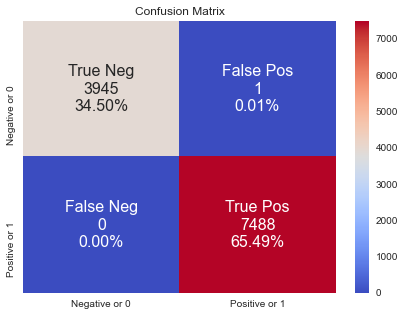

In [55]:
# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(y_test, y_pred)

### SGD Classifiers

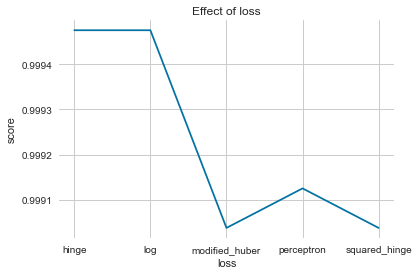

In [57]:
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    clf = SGDClassifier(loss=loss, penalty="l2", max_iter=1000)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 

In [58]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf_grid_sgd = SGDClassifier(max_iter=1000)
grid_sgd = GridSearchCV(clf_grid_sgd, param_grid=params, cv=5)


grid_sgd.fit(X_train, y_train)

print(grid_sgd.best_params_) 

KeyboardInterrupt: 

In [ ]:
grid_predictions = grid_sgd.predict(testX) 

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, grid_predictions)))